## Install dependencies

In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-l66ip9dg
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-l66ip9dg
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9175621d1235a335a667ee4796d7722e555a9e78
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-m6xm9w5c/elegantrl_5e5b7ee169fd4edb8b6464a0d48cbf49
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-m6xm9w5c/elegantrl_5e5b7ee169fd4edb8b6464a0d48cbf49
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 8ea76afc3e7f1564ae9f0e69e70254116d575fe9
  Preparing metadata (setup.py) ... done


In [2]:
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 190.2 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 10.4
    Uninstalling websockets-10.4:
      Successfully uninstalled websockets-10.4
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.58
    Uninstalling yfinance-0.2.58:
      Successfully uninstalled yfinance-0.2.58
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alpaca-trade-api 3.2.0 requires websockets<11,>=9.0, but you have websockets 15.0.1 which is incompatible.


In [3]:
import yfinance as yf
print(yf.__version__)

0.2.61


## Stage 1: Preprocessing

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS

import itertools

/usr/local/lib/python3.11/dist-packages/websockets/legacy/__init__.py:6: DeprecationWarning: websockets.legacy is deprecated; see https://websockets.readthedocs.io/en/stable/howto/upgrade.html for upgrade instructions
  warnings.warn(  # deprecated in 14.0 - 2024-11-09


In [5]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=600)

start_date = start_date.strftime("%Y-%m-%d")
end_date = end_date.strftime("%Y-%m-%d")

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  2023-09-30
End date:  2025-05-22


In [6]:
# Download NVDA hourly data
nvda_df_yf = yf.download(
    tickers="NVDA",
    start=start_date,
    end=end_date,
    interval="1h",
)

# Reset index and add 'tic' column for FinRL compatibility
nvda_df_yf.columns = nvda_df_yf.columns.get_level_values(0)
nvda_df_yf.reset_index(inplace=True)
nvda_df_yf.rename(columns={'Datetime': 'date'}, inplace=True)
nvda_df_yf['tic'] = 'NVDA'

# Reorder and rename columns to lowercase
nvda_df_yf = nvda_df_yf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Add a column for the day of the week (0 = Monday, 6 = Sunday)
nvda_df_yf['day'] = nvda_df_yf['date'].dt.dayofweek

# Optionally filter out weekends (since the market is closed)
nvda_df_yf = nvda_df_yf[nvda_df_yf['day'] < 5]

# Keep only needed columns for FinRL
nvda_df_yf = nvda_df_yf[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']]

nvda_df_yf.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,date,open,high,low,close,volume,tic,day
0,2023-10-02 13:30:00+00:00,44.029999,45.038002,43.861000,44.657001,14335903,NVDA,0
1,2023-10-02 14:30:00+00:00,44.659000,45.160999,44.558998,45.145000,6337526,NVDA,0
2,2023-10-02 15:30:00+00:00,45.150002,45.174999,44.579998,44.722000,5561964,NVDA,0
3,2023-10-02 16:30:00+00:00,44.720001,44.790001,44.471001,44.790001,3886473,NVDA,0
4,2023-10-02 17:30:00+00:00,44.783791,44.857002,44.381001,44.473499,3949976,NVDA,0


In [7]:
# Add technical indicators using FinRL's FeatureEngineer
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,  # Not available for hourly data
    use_turbulence=False,
    user_defined_feature=False
)

processed = fe.preprocess_data(nvda_df_yf)
processed

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2023-10-02 13:30:00+00:00,44.029999,45.038002,43.861000,44.657001,14335903,NVDA,0,0.000000,45.591136,44.210866,100.000000,66.666667,100.000000,44.657001,44.657001
1,2023-10-02 14:30:00+00:00,44.659000,45.160999,44.558998,45.145000,6337526,NVDA,0,0.010949,45.591136,44.210866,100.000000,66.666667,100.000000,44.901001,44.901001
2,2023-10-02 15:30:00+00:00,45.150002,45.174999,44.579998,44.722000,5561964,NVDA,0,0.000834,45.371301,44.311367,52.723271,23.901173,100.000000,44.841334,44.841334
3,2023-10-02 16:30:00+00:00,44.720001,44.790001,44.471001,44.790001,3886473,NVDA,0,-0.001332,45.264251,44.392751,56.169325,-28.626165,5.109414,44.828501,44.828501
4,2023-10-02 17:30:00+00:00,44.783791,44.857002,44.381001,44.473499,3949976,NVDA,0,-0.015075,45.250683,44.264317,41.577285,-65.040049,25.915546,44.757500,44.757500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,2025-05-21 15:30:00+00:00,135.875000,137.399994,135.720001,137.085007,35553645,NVDA,2,0.710140,136.665910,132.878663,66.156096,211.107403,4.924655,134.872304,130.328257
2857,2025-05-21 16:30:00+00:00,137.085007,137.399994,133.115005,133.214996,34652134,NVDA,2,0.524327,136.692994,132.669578,55.863505,-20.204762,23.515199,134.833304,130.592341
2858,2025-05-21 17:30:00+00:00,133.229996,134.220001,132.284698,132.845001,43037831,NVDA,2,0.343256,136.730709,132.408332,55.016943,-161.450073,28.292516,134.754251,130.870897
2859,2025-05-21 18:30:00+00:00,132.845001,133.445007,130.589996,131.078705,36210032,NVDA,2,0.056579,136.989610,131.725301,51.186274,-270.511651,36.892686,134.582874,131.115917


In [8]:
# Fill missing hourly time gaps
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max(), freq='1H'))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)

<ipython-input-8-776b17e8ebee>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  list_date = list(pd.date_range(processed['date'].min(), processed['date'].max(), freq='1H'))


In [9]:
columns = [
    'open', 'high', 'low', 'close', 'volume', 'macd',
    'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
    'close_30_sma', 'close_60_sma'
]

for col in columns:
    processed_full = processed_full[processed_full[col] != 0]

processed_full = processed_full.reset_index(drop=True)

In [10]:
processed_full.shape

(2857, 16)

In [ ]:
# stock market is only open 5 days per week (about 22 days per month), about 6 hours per day.

In [11]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2023-10-02 14:30:00+00:00,NVDA,44.659000,45.160999,44.558998,45.145000,6337526.0,0.0,0.010949,45.591136,44.210866,100.000000,66.666667,100.000000,44.901001,44.901001
1,2023-10-02 15:30:00+00:00,NVDA,45.150002,45.174999,44.579998,44.722000,5561964.0,0.0,0.000834,45.371301,44.311367,52.723271,23.901173,100.000000,44.841334,44.841334
2,2023-10-02 16:30:00+00:00,NVDA,44.720001,44.790001,44.471001,44.790001,3886473.0,0.0,-0.001332,45.264251,44.392751,56.169325,-28.626165,5.109414,44.828501,44.828501
3,2023-10-02 17:30:00+00:00,NVDA,44.783791,44.857002,44.381001,44.473499,3949976.0,0.0,-0.015075,45.250683,44.264317,41.577285,-65.040049,25.915546,44.757500,44.757500
4,2023-10-02 18:30:00+00:00,NVDA,44.479839,44.543999,44.256001,44.489498,3797295.0,0.0,-0.022369,45.205243,44.220424,42.360308,-99.036774,48.489074,44.712833,44.712833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,2025-05-21 15:30:00+00:00,NVDA,135.875000,137.399994,135.720001,137.085007,35553645.0,2.0,0.710140,136.665910,132.878663,66.156096,211.107403,4.924655,134.872304,130.328257
2853,2025-05-21 16:30:00+00:00,NVDA,137.085007,137.399994,133.115005,133.214996,34652134.0,2.0,0.524327,136.692994,132.669578,55.863505,-20.204762,23.515199,134.833304,130.592341
2854,2025-05-21 17:30:00+00:00,NVDA,133.229996,134.220001,132.284698,132.845001,43037831.0,2.0,0.343256,136.730709,132.408332,55.016943,-161.450073,28.292516,134.754251,130.870897
2855,2025-05-21 18:30:00+00:00,NVDA,132.845001,133.445007,130.589996,131.078705,36210032.0,2.0,0.056579,136.989610,131.725301,51.186274,-270.511651,36.892686,134.582874,131.115917


In [12]:
# Split into train/test
TRAIN_START_DATE = processed_full['date'].min()
TRAIN_END_DATE = processed_full['date'].iloc[int(len(processed_full) * 0.8)]
TRADE_START_DATE = processed_full['date'].iloc[int(len(processed_full) * 0.8) + 1]
TRADE_END_DATE = processed_full['date'].max()

train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)

print(f'Train start date: {TRAIN_START_DATE}')
print(f'Train end date: {TRAIN_END_DATE}')
print(f'Trade start date: {TRADE_START_DATE}')
print(f'Trade end date: {TRADE_END_DATE}')

print(f"Train size: {len(train)} rows")
print(f"Trade size: {len(trade)} rows")

Train start date: 2023-10-02 14:30:00+00:00
Train end date: 2025-01-24 16:30:00+00:00
Trade start date: 2025-01-24 17:30:00+00:00
Trade end date: 2025-05-21 19:30:00+00:00
Train size: 2285 rows
Trade size: 570 rows


In [13]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## Stage 2: Training

In [14]:
import pandas as pd
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

In [15]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

### Agent: A2C

In [16]:
# Environment setup
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [19]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension  # 0.1% trading cost
num_stock_shares = [0] * stock_dimension

env_kwargs_a2c = {
    "hmax": 500,                         # Max shares to trade per step
    "initial_amount": 100000,           # Lower for intraday
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-10             # Smaller for hourly granularity
}

e_train_gym_a2c = StockTradingEnv(df = train, **env_kwargs_a2c)
env_train_a2c, _ = e_train_gym_a2c.get_sb_env()

In [20]:
# Initialize A2C agent
agent_a2c = DRLAgent(env=env_train_a2c)
model_a2c = agent_a2c.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [21]:
# Train the agent
trained_a2c = agent_a2c.train_model(
    model=model_a2c,
    tb_log_name='a2c_hourly',
    total_timesteps=150000   # Slightly more steps due to smaller interval
)

-------------------------------------
| time/                 |           |
|    fps                | 406       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.56     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.08e-06 |
|    reward             | 0.0       |
|    std                | 1.15      |
|    value_loss         | 4.96e-13  |
-------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 416            |
|    iterations         | 200            |
|    time_elapsed       | 2              |
|    total_timesteps    | 1000           |
| train/                |                |
|    entropy_loss       | -1.64          |
|    explained_variance | 0              |
|    

In [22]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c")

### Agent: SAC

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension  # 0.1% trading cost
num_stock_shares = [0] * stock_dimension

env_kwargs_sac = {
    "hmax": 500,                         # Max shares to trade per step
    "initial_amount": 100000,           # Lower for intraday
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-10             # Smaller for hourly granularity
}

e_train_gym_sac = StockTradingEnv(df = train, **env_kwargs_sac)
env_train_sac, _ = e_train_gym_sac.get_sb_env()

In [ ]:
# Initialize SAC agent
agent_sac = DRLAgent(env = env_train_sac)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent_sac.get_model("sac", model_kwargs = SAC_PARAMS)

tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [ ]:
trained_sac = agent_sac.train_model(model=model_sac,
                             tb_log_name='sac_hourly',
                             total_timesteps=150000)

---------------------------------------
| time/              |                |
|    episodes        | 4              |
|    fps             | 51             |
|    time_elapsed    | 178            |
|    total_timesteps | 9140           |
| train/             |                |
|    actor_loss      | 217            |
|    critic_loss     | 480            |
|    ent_coef        | 0.247          |
|    ent_coef_loss   | 13.2           |
|    learning_rate   | 0.0001         |
|    n_updates       | 9039           |
|    reward          | -1.8972136e-07 |
---------------------------------------
---------------------------------------
| time/              |                |
|    episodes        | 8              |
|    fps             | 50             |
|    time_elapsed    | 362            |
|    total_timesteps | 18280          |
| train/             |                |
|    actor_loss      | 300            |
|    critic_loss     | 0.853          |
|    ent_coef        | 0.616          |


In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


## Stage 3: Backtesting

### Load trade dataset and trained models

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, SAC
from pypfopt.efficient_frontier import EfficientFrontier
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from gymnasium import spaces

%matplotlib inline

In [3]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:
trade.head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
,,,,,,,,,,,,,,,,
0,2025-01-10 16:30:00+00:00,NVDA,135.610001,136.199997,135.000000,136.169998,19282492.0,4.0,-1.620850,150.122909,133.051581,43.763520,-137.347248,21.105183,143.435543,140.265718
1,2025-01-10 17:30:00+00:00,NVDA,136.160004,136.895004,136.100006,136.529999,15418478.0,4.0,-1.706231,148.663292,133.134699,44.353088,-114.309595,16.330377,143.204540,140.209718
2,2025-01-10 18:30:00+00:00,NVDA,136.520004,137.109894,135.770004,136.240005,15407385.0,4.0,-1.776814,146.757316,133.612176,43.968965,-107.391054,17.971897,142.956530,140.219720
3,2025-01-10 19:30:00+00:00,NVDA,136.229996,136.466705,135.421402,135.649994,14690719.0,4.0,-1.858932,144.706907,134.276574,43.181841,-107.529079,19.749777,142.661687,140.199490
4,2025-01-10 20:30:00+00:00,NVDA,135.639999,136.130005,135.419998,135.860001,13963294.0,4.0,-1.885333,144.169418,134.034262,43.553913,-101.173769,19.757264,142.377987,140.202156


In [53]:
# Load the pre-trained model
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c")
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac")

### Load sentiment risk scores

In [25]:
## Load aggregated_risk_scores
sentiment_df = pd.read_csv('aggregated_risk_scores.csv')

# Rename columns for consistency
sentiment_df = sentiment_df.rename(columns={"datetime": "date", "avg_weighted_score": "risk_score"})

# Convert to datetime and localize to UTC
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.tz_localize('UTC')

In [ ]:
sentiment_df.head(5)

,date,risk_score
0,2025-03-15 17:30:00+00:00,4
1,2025-03-16 12:30:00+00:00,3
2,2025-03-17 19:30:00+00:00,3
3,2025-03-17 23:30:00+00:00,5
4,2025-03-18 18:30:00+00:00,4


In [26]:
# Merge with UTC-aligned trade['date']
trade_copy = trade.copy()
trade_copy['date'] = pd.to_datetime(trade_copy['date'], utc=True)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], utc=True)
trade_sentiment = pd.merge(trade_copy, sentiment_df, on='date', how='left')

# Fill missing risk scores with 0
trade_sentiment['risk_score'] = trade_sentiment['risk_score'].fillna(0)

trade_sentiment.head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,risk_score
0,2025-01-24 17:30:00+00:00,NVDA,144.429993,144.615402,142.619995,143.389999,25876751.0,4.0,1.354193,149.131748,141.993882,54.225622,4.438704,7.962048,143.355870,138.580707,0.0
1,2025-01-24 18:30:00+00:00,NVDA,143.389999,143.570007,141.940094,142.310104,30513147.0,4.0,1.024875,149.008064,142.190577,51.977979,-18.722875,2.174658,143.500589,138.773377,0.0
2,2025-01-24 19:30:00+00:00,NVDA,142.309998,142.850006,141.880005,142.035004,20342241.0,4.0,0.733237,148.740176,142.578964,51.416340,-30.844221,1.659815,143.626423,138.946710,0.0
3,2025-01-24 20:30:00+00:00,NVDA,142.024994,142.835999,141.899994,142.600403,21485810.0,4.0,0.541493,148.817453,142.123837,52.507405,-31.748920,1.659815,143.776770,139.112884,0.0
4,2025-01-27 14:30:00+00:00,NVDA,124.790001,128.399994,123.050003,124.029999,243794418.0,0.0,-1.096305,154.512756,134.231034,29.782237,-371.934491,63.773591,143.321603,138.971467,0.0


### Prediction for Agent 1

In [54]:
# Setup the environment
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension

#### A2C Agent 1

In [55]:
env_kwargs_a2c = {
    "hmax": 500,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-10,
}

e_train_gym_a2c = StockTradingEnv(df = trade, **env_kwargs_a2c)
env_train_a2c, _ = e_train_gym_a2c.get_sb_env()

In [56]:
df_account_value_a2c_agent1, df_actions_a2c_agent1 = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_train_gym_a2c
)

hit end!


#### SAC Agent 2

In [57]:
env_kwargs_sac = {
    "hmax": 500,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-10,
}

e_train_gym_sac = StockTradingEnv(df = trade, **env_kwargs_sac)
env_train_sac, _ = e_train_gym_sac.get_sb_env()

In [58]:
# SAC
df_account_value_sac_agent1, df_actions_sac_agent1 = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_train_gym_sac
)

hit end!


### Prediction for Agent 2

#### custom trading environment

In [104]:
# custom trading environment

class RiskAwareStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
        self.risk_score_col = 'risk_score'
        super().__init__(df, **kwargs)

    def step(self, actions):
        state, reward, done, truncated, info = super().step(actions)

        # Get the risk score
        day_idx = max(0, self.day - 1)
        try:
            risk_score = self.df.loc[day_idx, self.risk_score_col]
            risk_score = risk_score if pd.notnull(risk_score) else 0
        except KeyError:
            risk_score = 0

        # Inject risk into state indirectly (scale the cash balance)
        risk_weight = self._get_risk_scaling_factor(risk_score)

        # Assume state[0] = cash balance
        state[0] = state[0] * risk_weight

        return state, reward, done, truncated, info

    def _get_risk_scaling_factor(self, risk_score):
        if risk_score == 0:
            return 1  # No change
        elif 1 <= risk_score <= 2:
            return 5  # More optimistic
        elif risk_score == 3:
            return 3  # Slight optimistic
        elif 4 <= risk_score <= 5:
            return 0.9  # Slight caution
        else:
            return 1.0


#### A2C Agent 2

In [105]:
# Setup the environment
stock_dimension_agent2 = len(trade.tic.unique())
state_space_agent2 = 1 + 2 * stock_dimension_agent2 + len(INDICATORS) * stock_dimension_agent2

In [106]:
env_kwargs_agent2 = {
    "hmax": 500,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_dimension_agent2,
    "buy_cost_pct": [0.001] * stock_dimension_agent2,
    "sell_cost_pct": [0.001] * stock_dimension_agent2,
    "state_space": state_space_agent2,
    "stock_dim": stock_dimension_agent2,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension_agent2,
    "reward_scaling": 1e-10,
}

# Initialize custom environment with trade_sentiment data
e_trade_sentiment = RiskAwareStockTradingEnv(df=trade_sentiment, **env_kwargs_agent2)

# Create the Stable-Baselines compatible wrapper
env_trade_sentiment, _ = e_trade_sentiment.get_sb_env()

In [107]:
df_account_value_a2c_agent2, df_actions_a2c_agent2 = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_trade_sentiment
)

hit end!


#### SAC Agent 2

In [108]:
df_account_value_sac_agent2, df_actions_sac_agent2 = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment=e_trade_sentiment
)

hit end!


### MVO and DJIA

In [74]:
# Convert trade data into MVO format
def process_df_for_mvo(df):
    df = df.sort_values(['date', 'tic'], ignore_index=True)[['date', 'tic', 'close']]
    df['date'] = pd.to_datetime(df['date'], utc=True)
    tickers = df['tic'].unique()
    mvo = pd.DataFrame(columns=tickers)

    for i in range(df.shape[0] // len(tickers)):
        temp = df.iloc[i * len(tickers):(i + 1) * len(tickers)]
        date = temp['date'].iloc[0]
        mvo.loc[date] = temp['close'].values

    mvo.index = pd.to_datetime(mvo.index, utc=True)
    return mvo

In [75]:
StockData = process_df_for_mvo(trade)
arStockPrices = StockData.to_numpy()
rows, cols = arStockPrices.shape

In [76]:
def StockReturnsComputing(StockPrice, Rows, Columns):
    StockReturn = np.zeros([Rows - 1, Columns])
    for j in range(Columns):
        for i in range(Rows - 1):
            StockReturn[i, j] = ((StockPrice[i + 1, j] - StockPrice[i, j]) / StockPrice[i, j]) * 100
    return StockReturn

In [77]:
arReturns = StockReturnsComputing(arStockPrices, rows, cols)
meanReturns = np.mean(arReturns, axis=0).reshape(-1)
covReturns = np.cov(arReturns, rowvar=False) + np.eye(cols) * 1e-6

In [78]:
print("Mean Returns:", meanReturns)
print("Covariance Matrix:", covReturns)

Mean Returns: [-0.00371312]
Covariance Matrix: [[2.38691035]]


In [79]:
# Efficient Frontier
ef = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 1))
weights = ef.min_volatility() if stock_dimension == 1 else ef.max_sharpe(solver="SCS")

cleaned_weights_mean = ef.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(stock_dimension)])

In [80]:
mvo_weights

array([1000000.])

In [81]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([7629.00427851])

In [82]:
TradeData = process_df_for_mvo(trade)
TradeData.to_numpy()

Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

In [83]:
# Benchmark: Hourly DJI
TRADE_START_DATE = trade["date"].iloc[0]
TRADE_END_DATE = trade["date"].iloc[-1]

TRADE_START_DATE = pd.to_datetime(TRADE_START_DATE)
TRADE_END_DATE = pd.to_datetime(TRADE_END_DATE)

trade_start_date = TRADE_START_DATE.strftime("%Y-%m-%d")
trade_end_date = TRADE_END_DATE.strftime("%Y-%m-%d")

# Download DJIA hourly data between TRADE_START_DATE and TRADE_END_DATE
df_dji = yf.download(
    tickers="^DJI",  # DJIA Index ticker
    start=trade_start_date,
    end=trade_end_date,
    interval="1h",
)

# Reset index and rename columns to match desired format
df_dji = df_dji.reset_index()
df_dji = df_dji.rename(columns={'Datetime': 'date'})
df_dji['date'] = pd.to_datetime(df_dji['date'], utc=True)
df_dji['tic'] = '^DJI'

# Reorder and rename columns to lowercase (to match NVDA format)
df_dji = df_dji.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Add a column for the day of the week (0 = Monday, 6 = Sunday)
df_dji['day'] = df_dji['date'].dt.dayofweek

# Filter out weekends (market is closed)
df_dji = df_dji[df_dji['day'] < 5]  # Only weekdays

[*********************100%***********************]  1 of 1 completed


In [84]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'].iloc[0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

### Merge Results

In [48]:
def ensure_utc_index(df):
    df.index = pd.to_datetime(df.index, utc=True)
    return df

In [109]:
df_result_a2c_agent1 = ensure_utc_index(df_account_value_a2c_agent1.set_index(df_account_value_a2c_agent1.columns[0]))
df_result_a2c_agent1.columns = ['a2c_agent1']

df_result_a2c_agent2 = ensure_utc_index(df_account_value_a2c_agent2.set_index(df_account_value_a2c_agent2.columns[0]))
df_result_a2c_agent2.columns = ['a2c_agent2']

df_result_sac_agent1 = ensure_utc_index(df_account_value_sac_agent1.set_index(df_account_value_sac_agent1.columns[0]))
df_result_sac_agent1.columns = ['sac_agent1']

df_result_sac_agent2 = ensure_utc_index(df_account_value_sac_agent2.set_index(df_account_value_sac_agent2.columns[0]))
df_result_sac_agent2.columns = ['sac_agent2']

MVO_result.columns = ['mvo']
dji.columns = ['dji']

result = pd.DataFrame()

# Merge
result = df_result_a2c_agent1.copy()
result = result.join(df_result_a2c_agent2, how='outer')
result = result.join(df_result_sac_agent1, how='outer')
result = result.join(df_result_sac_agent2, how='outer')
result = result.join(MVO_result, how='outer')
result = result.join(dji, how='outer')

# Fill missing values by backfilling
result = result.fillna(method='bfill')

<ipython-input-109-f1a5e95d707c>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = result.fillna(method='bfill')


In [110]:
col_name = ['A2C Agent1', 'A2C Agent 2', 'SAC Agent1', 'SAC Agent 2', 'Mean Var', 'djia']
result.columns = col_name
result = result.dropna(subset=['djia'])
result

,A2C Agent1,A2C Agent 2,SAC Agent1,SAC Agent 2,Mean Var,djia
date,,,,,,
2025-01-24 14:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.093923e+06,1.000000e+06
2025-01-24 15:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.093923e+06,1.001042e+06
2025-01-24 16:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.093923e+06,1.000896e+06
2025-01-24 17:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.093923e+06,9.999896e+05
2025-01-24 18:30:00+00:00,9.998434e+05,9.998434e+05,9.993884e+05,9.993884e+05,1.085684e+06,9.984511e+05
...,...,...,...,...,...,...
2025-05-20 15:30:00+00:00,1.088369e+06,1.108366e+06,1.056990e+06,1.078588e+06,1.022932e+06,9.590951e+05
2025-05-20 16:30:00+00:00,1.088535e+06,1.108581e+06,1.057151e+06,1.078774e+06,1.023088e+06,9.600978e+05
2025-05-20 17:30:00+00:00,1.083218e+06,1.103305e+06,1.051988e+06,1.073573e+06,1.018091e+06,9.564954e+05


In [96]:
result.to_csv('result.csv')

<Figure size 1500x500 with 0 Axes>

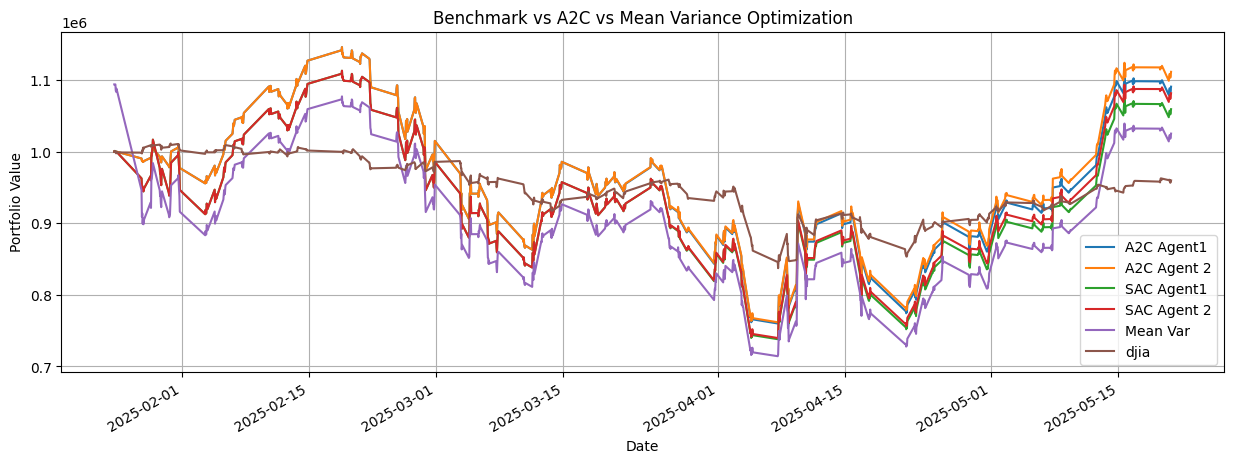

In [111]:
# Convert the index to datetime
result.index = pd.to_datetime(result.index)
result = result.sort_index()

# Plotting
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title("Benchmark vs A2C vs Mean Variance Optimization")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(loc="best")
plt.grid(True)
plt.show()